In [1]:
import phylovelo as pv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from copy import deepcopy
from tqdm import tqdm
import pandas as pd
%matplotlib inline
from itertools import product
from scipy.stats import nbinom
from matplotlib_venn import venn3

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
data_path = '/data3/wangkun/phylovelo_datasets/'

In [3]:
tree_file = data_path + 'bifurcation_model/tree_origin_var0.02_rvg0.05.csv0.nwk'

In [6]:
phylo_tree, branch_colors = pv.loadtree(tree_file)
sampled_cells = [i.name for i in phylo_tree.get_terminals()]
# fig, ax = plt.subplots(figsize=(10,20))
# plot_tree(phylo_tree, branch_colors, ax=ax, stain='terminals')

In [37]:
cell_names, cell_states, cell_generation = pv.get_annotation(data_path+'bifurcation_model/tree_origin_var0.02_rvg0.05.csv0')

In [7]:
cell_states = pd.DataFrame(data=cell_states, index=cell_names)
cell_states = cell_states.loc[sampled_cells]
cell_generation = pd.DataFrame(data=cell_generation, index=cell_names)
cell_generation = cell_generation.loc[sampled_cells]
cell_generation = cell_generation.to_numpy()

In [8]:
sd = scData(phylo_tree=phylo_tree, 
            cell_states=cell_states.to_numpy().T[0].astype('int'), 
            cell_generation=cell_generation.T[0].astype('int'),
            cell_names=sampled_cells)

In [12]:
# sd.count = pd.read_csv('../datas/bifurcation_model/read_count.csv', index_col=0)

In [109]:
ge, base_expr = sim_base_expr(sd.phylo_tree, 
                                 cell_states,
                                 Ngene=2000, 
                                 r_variant_geneA=0.4, 
                                 variance=0.005, 
                                 avg_drift=0.5,
                                 diff_map={0:[0],1:[0],2:[0],3:[1],4:[1]},
                                 pseudo_state_time={0:[0,5], 1:[7,12], 2:[7,12], 3:[13,18], 4:[13,18]},
                                 forward_map = {}
                             )


/home/wangkun/LineageTracingwithscRNA/sim_utils.py:88: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  base_expr[cell.name] = ge.expr(cellstate, int(terminals_depths[cell]) - t0 - start_time[cellstate] + pseudo_start_time[cellstate])


In [110]:
sd.count = get_count_from_base_expr(add_lineage_noise(sd.phylo_tree, base_expr), alpha=0.05)

In [111]:
sd.dimensionality_reduction(methor='tsne', scale=1, n_highly_variable_genes=0, perplexity=50, target='count')

/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


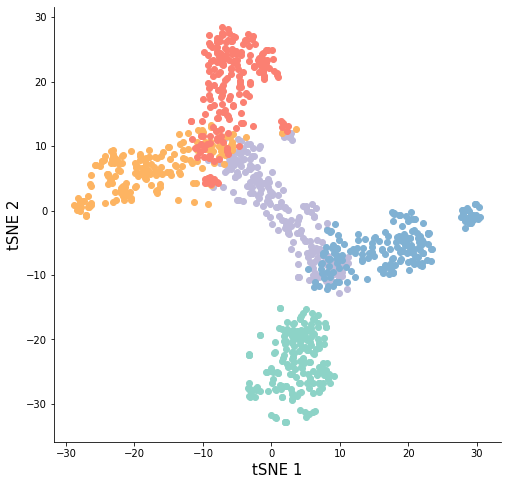

In [151]:
fig, ax = plt.subplots(figsize=(8, 8))
cmps = ['#8dd3c7','#bebada','#80b1d3','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
plt.savefig('./figures/Bifurcated/tsne.pdf', format='pdf')

In [113]:
def is_meg(x):
    x1 = np.array([x[0], x[1], x[3]])
    x2 = np.array([x[0], x[1], x[4]])
    return np.all(x<=0) or np.all(x>=0)

In [114]:
drifts = pd.DataFrame(data=np.array([np.array([ge.cells[ct][g].drift for ct in range(5)]) for g in range(2000)]), index=range(2000))
megs = set(np.arange(2000)[drifts.apply(is_meg, axis=1)])

In [116]:
# sd.count.to_csv('../datas/bifurcation_model/read_count.csv')

In [117]:
from scipy.stats import spearmanr
megs0 = set()
for i in megs:
    try:
        if abs(spearmanr(sd.count[i], sd.cell_generation)[0]) > 0.3:
            megs0.add(i)
    except:
        None

In [216]:
sd.normalize_filter()

/home/wangkun/LineageTracingwithscRNA/data_struct.py:58: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.x_normed = np.divide(self.count, counts_per_cell[:, None])


In [223]:
sd = velocity_inference(sd, sd.cell_generation, cutoff=0.9, target='count')

/home/wangkun/LineageTracingwithscRNA/inference.py:173: RuntimeWarning: invalid value encountered in log
  y = np.log(y+1)
/home/wangkun/LineageTracingwithscRNA/inference.py:16: RuntimeWarning: invalid value encountered in double_scalars
  pmf0 = -n_zeros*np.log((1-psi)+psi*(n/(n+mu))**n)
/home/wangkun/LineageTracingwithscRNA/inference.py:16: RuntimeWarning: divide by zero encountered in log
  pmf0 = -n_zeros*np.log((1-psi)+psi*(n/(n+mu))**n)
/home/wangkun/LineageTracingwithscRNA/inference.py:16: RuntimeWarning: invalid value encountered in multiply
  pmf0 = -n_zeros*np.log((1-psi)+psi*(n/(n+mu))**n)


In [227]:
sd = velocity_embedding(sd, target='count')

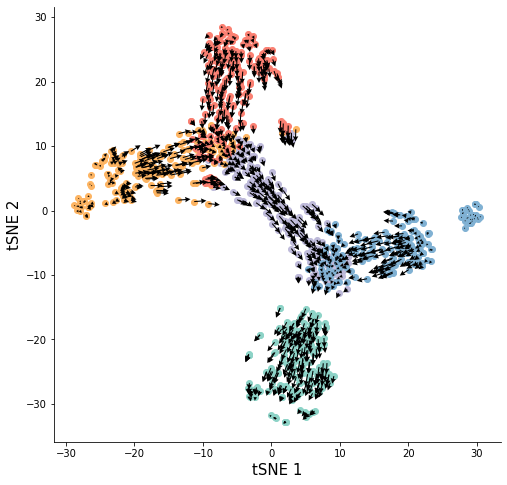

In [154]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#bebada','#80b1d3','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'point',headwidth=5)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-35, 35)
plt.savefig('./figures/Bifurcated/quiver.pdf', format='pdf')

In [219]:
from scipy.stats import spearmanr

In [143]:
mutation_tree = deepcopy(sd.phylo_tree)
mut_rate = 0.1
for i in mutation_tree.get_nonterminals():
    i.branch_length = np.random.poisson(mut_rate)

for i in mutation_tree.get_terminals():
    i.branch_length = np.random.poisson(mut_rate)

depths1 = np.array([mutation_tree.depths()[mutation_tree.find_any(name=i)] for i in sd.count.index])

In [144]:
sd = velocity_inference(sd, depths1, cutoff=0.9, target='count', exact=True)
sd = velocity_embedding(sd, target='count', n_neigh=200)

/home/wangkun/LineageTracingwithscRNA/inference.py:173: RuntimeWarning: invalid value encountered in log
  y = np.log(y+1)


mu=1


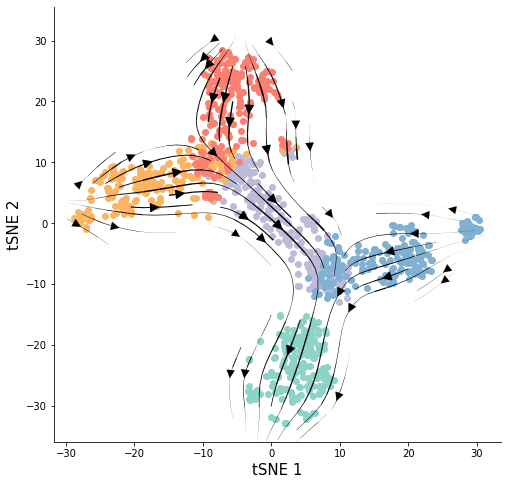

In [134]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#bebada','#80b1d3','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=500, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim(-50, 50)
print('mu=1')

mu=0.3


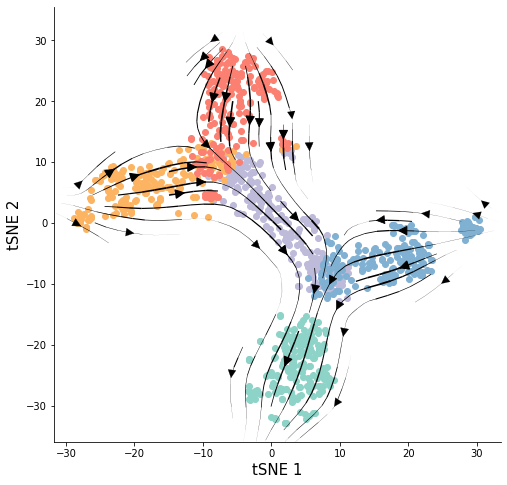

In [138]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#bebada','#80b1d3','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=500, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim(-50, 50)
print('mu=0.3')

mu=0.1


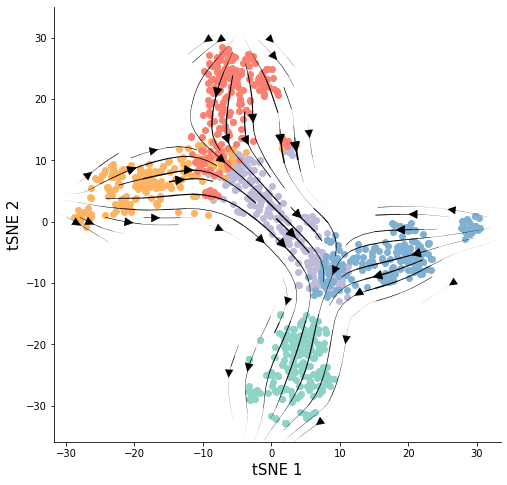

In [147]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#bebada','#80b1d3','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=1000, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim(-50, 50)
print('mu=0.1')

In [233]:
drifts.to_csv('../datas/line_model/drifts_branch.csv')

In [240]:
import seaborn as sns
from sklearn.preprocessing import scale

def expr_sort(gene, states):
    expr = []
    for state in states:
        t = list(ge.expr_rec[state].keys())
        t.sort()
        expr.append([ge.expr_rec[state][i][gene] for i in t])
    return sum(expr, [])

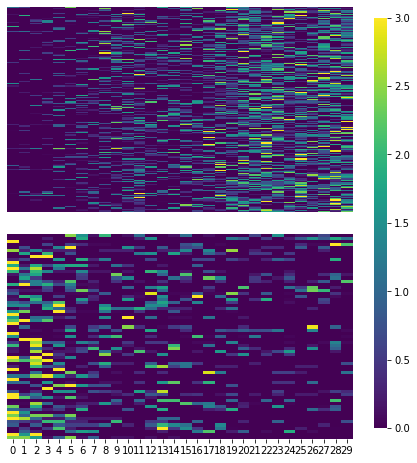

In [254]:
fig = plt.figure(figsize=(6, 6))
h1 = 0.5
h2 = 0.5
ax1 = plt.axes([0.05, 0, 0.8, 0.95*h1])
ax2 = plt.axes([0.05, 0.95*h1+0.05, 0.8, 0.95*h2])
ax3 = plt.axes([0.9,0.025,0.03,0.95])

expr_mat = np.array([expr_sort(i, range(5)) for i in drifts.loc[megs].index[drifts.loc[megs][4]<0]])
expr_mat = expr_mat[expr_mat[:,0]!=0]
expr_mat = get_count_from_base_expr(pd.DataFrame(expr_mat), alpha= 0.1)
for i in expr_mat.index:
    expr_mat.loc[i] = scale(expr_mat.loc[i])
ax1 = sns.heatmap(expr_mat[expr_mat.sum(axis=1)!=0], cmap='viridis', ax=ax1, vmax=3, vmin=0, cbar_ax=ax3, yticklabels='')
n1 = sum(expr_mat.sum(axis=1)!=0)

expr_mat = np.array([expr_sort(i, range(5)) for i in drifts.loc[megs].index[drifts.loc[megs][4]>0]])
expr_mat = expr_mat[expr_mat[:,0]!=0]
expr_mat = get_count_from_base_expr(pd.DataFrame(expr_mat), alpha= 0.1)
for i in expr_mat.index:
    expr_mat.loc[i] = scale(expr_mat.loc[i])
ax2 = sns.heatmap(expr_mat.sample(170+77-n1), cmap='viridis', ax=ax2, cbar=False, vmax=3, vmin=0, xticklabels=False, yticklabels='')
ax1.tick_params(axis='x', labelrotation=0)

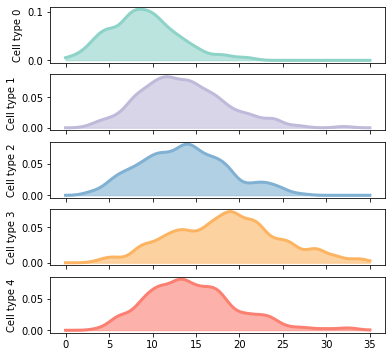

In [283]:
fig, ax = plt.subplots(5, 1, figsize=(6, 6), sharex=True)
# g += 1
cmps = ['#8dd3c7','#bebada','#80b1d3','#fdb462','#fb8072']
from sklearn.neighbors import KernelDensity
for i in range(5):  
    ax[i].set_ylabel(f'Cell type {i}', fontsize=10)
    data_kde = sd.count[g][sd.cell_states==i].to_numpy()
    kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(data_kde[:, np.newaxis])
    x_kde = np.linspace(0,35,100)
    y_kde = np.exp(kde.score_samples(x_kde[:, np.newaxis]))
    ax[i].plot(x_kde, y_kde, c=cmps[i], lw=3)
    ax[i].fill_between(x_kde, y_kde, color=cmps[i], alpha=0.6)
    # ax[i].vlines(np.mean(data_kde), 0, np.exp(kde.score_samples([[np.mean(data_kde)]])), color='black', lw=2)
    
# ax[i].set_xlabel(f'Cell', fontsize=15)

In [284]:
model = 'bifurcated'
from scipy.stats import zscore
sd.count.to_csv(f'{model}_cnt.csv')
sd.normalize_filter()
sd.x_normed.to_csv(f'{model}_norm.csv')
zscore(sd.x_normed).to_csv(f'{model}_zscore.csv')

/home/wangkun/LineageTracingwithscRNA/data_struct.py:58: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.x_normed = np.divide(self.count, counts_per_cell[:, None])


In [285]:
tree, branch_colors = loadtree(tree_file)
mutations = dict()
global_mutid = 0

In [286]:
mu = 0.3
for i in tree.get_terminals():
    mut = []
    for j in tree.get_path(i):
        if j.name in mutations:
            mut = deepcopy(mutations[j.name])
        else:
            for _ in range(np.random.poisson(mu)):
                mut.append(global_mutid+1)
                global_mutid += 1
            mutations[j.name] = deepcopy(mut)

mut_table = []
cell_nemes = []
for i in tree.get_terminals():
    seq = np.zeros(global_mutid+1)
    seq[mutations[i.name]]=1
    mut_table.append(seq)
    cell_nemes.append(i.name)

In [287]:
mut_table = pd.DataFrame(data=mut_table, index=cell_nemes).iloc[:,1:]
mut_table.astype('int').to_csv('bifurcated.csv')

In [73]:
tree, branch_colors = pv.loadtree(tree_file)
mutations = dict()

mu = 2
len_seq = 500
for i in tree.get_terminals():
    mut = np.zeros(len_seq)
    for j in tree.get_path(i):
        if j.name in mutations:
            mut = deepcopy(mutations[j.name])
        else:
            mut[np.random.choice(range(len_seq), np.random.poisson(mu))] = 1
            mutations[j.name] = deepcopy(mut)

mut_table = []
cell_nemes = []
for i in tree.get_terminals():
    mut_table.append(mutations[i.name])
    cell_nemes.append(i.name)

In [74]:
mut_table = pd.DataFrame(data=mut_table, index=cell_nemes).astype('int')
with open('/data3/wangkun/bifurcated.phy', 'w') as f:
    f.write('{} {}\n'.format(*mut_table.shape))
    for cell in mut_table.index:
        f.write('{} {}\n'.format(cell[1:-1], ''.join(mut_table.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))

In [79]:
from Bio import Phylo
tree_nj = Phylo.read('/data3/wangkun/bifurcated_nj.nwk', 'newick')
tree_mp = Phylo.read('/data3/wangkun/bifurcated_mp.nwk', 'newick')
tree_ml = Phylo.read('/data3/wangkun/bifurcated.phy.treefile', 'newick')

In [102]:
tree_depths = tree_nj.depths()
depths_map = dict()
for i in tree_depths:
    depths_map[i.name] = tree_depths[i]
depths_nj = [depths_map[i[1:-1]] for i in cell_nemes]

tree_depths = tree_mp.depths()
depths_map = dict()
for i in tree_depths:
    depths_map[i.name] = tree_depths[i]
depths_mp = [depths_map[i[1:-1]] for i in cell_nemes]

tree_depths = tree_ml.depths()
depths_map = dict()
for i in tree_depths:
    depths_map[i.name] = tree_depths[i]
depths_ml = [depths_map[i[1:-1]] for i in cell_nemes]

In [120]:
tree_depths = tree_nj.depths()
depths_map = dict()
for i in tree_nj.get_terminals():
    depths_map[i.name] = len(tree_nj.get_path(i))
depths_nj = [depths_map[i[1:-1]] for i in cell_nemes]

tree_depths = tree_mp.depths()
depths_map = dict()
for i in tree_mp.get_terminals():
    depths_map[i.name] = len(tree_mp.get_path(i))
depths_mp = [depths_map[i[1:-1]] for i in cell_nemes]

tree_depths = tree_ml.depths()
depths_map = dict()
for i in tree_ml.get_terminals():
    depths_map[i.name] = len(tree_ml.get_path(i))
depths_ml = [depths_map[i[1:-1]] for i in cell_nemes]

<AxesSubplot: >

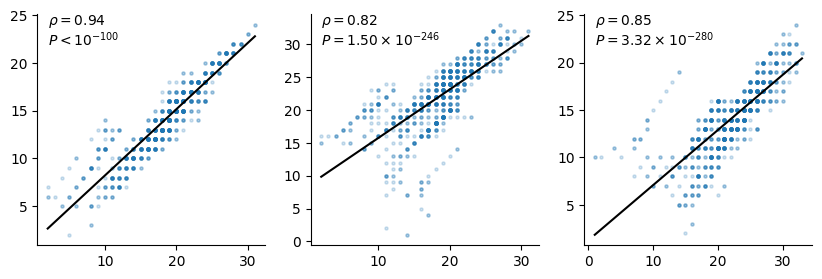

In [122]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
corr_plot(depths_mp, depths_nj, ax[0], 'spearman')
corr_plot(depths_mp, depths_ml, ax[1], 'spearman')
corr_plot(depths_ml, depths_nj, ax[2], 'spearman')

In [82]:
import pickle
sd = pickle.load(open('/data3/wangkun/result_sd/simulation_bifurcated.pkl', 'rb'))
dir_gt = sd.velocity_embeded[:,0]/np.sqrt((sd.velocity_embeded**2).sum(axis=1))

In [83]:
sd.normalize_filter()

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/data_struct.py:114: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.x_normed = np.divide(self.count, counts_per_cell[:, None])


In [103]:
sd = pv.velocity_inference(sd, depths_nj, exact=True)
sd = pv.velocity_embedding(sd)
dir_nj = sd.velocity_embeded[:,0]/np.sqrt((sd.velocity_embeded**2).sum(axis=1))

  0%|          | 0/1997 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

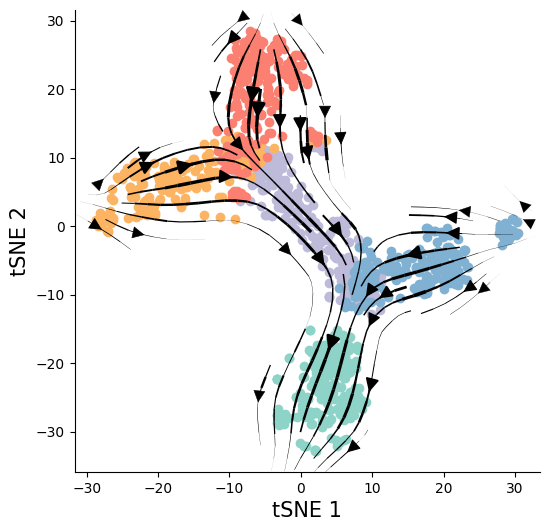

In [104]:
fig, ax = plt.subplots(figsize=(6, 6))
cmps = ['#8dd3c7','#bebada','#80b1d3','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=600, arrowsize=2)
# ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim(-45, 45)

In [105]:
sd = pv.velocity_inference(sd, depths_mp, exact=True)
sd = pv.velocity_embedding(sd)
dir_mp = sd.velocity_embeded[:,0]/np.sqrt((sd.velocity_embeded**2).sum(axis=1))

  0%|          | 0/1997 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

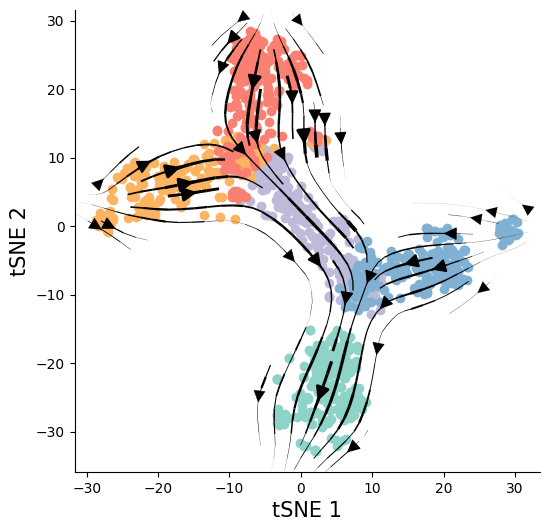

In [106]:
fig, ax = plt.subplots(figsize=(6, 6))
cmps = ['#8dd3c7','#bebada','#80b1d3','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=600, arrowsize=2)
# ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim(-45, 45)

In [117]:
sd = pv.velocity_inference(sd, depths_ml, exact=True)
sd = pv.velocity_embedding(sd)
dir_ml = sd.velocity_embeded[:,0]/np.sqrt((sd.velocity_embeded**2).sum(axis=1))

  0%|          | 0/1997 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

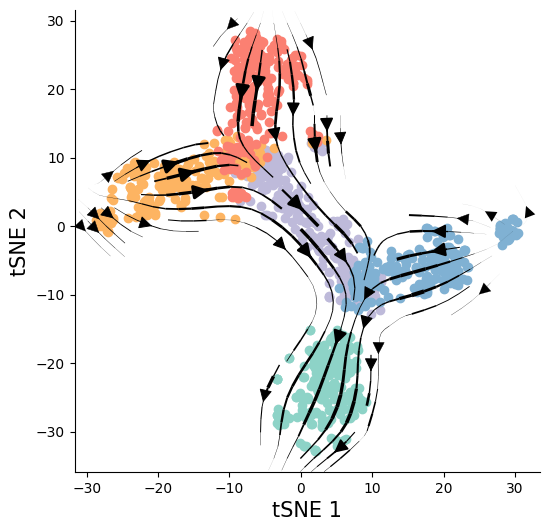

In [118]:
fig, ax = plt.subplots(figsize=(6, 6))
cmps = ['#8dd3c7','#bebada','#80b1d3','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=600, arrowsize=2)
# ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim(-45, 45)

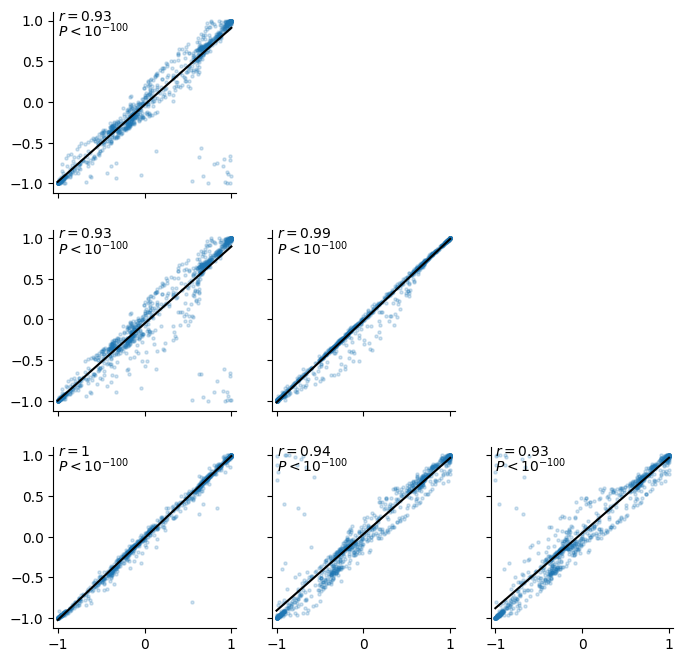

In [119]:
dirs = [dir_gt, dir_mp, dir_nj, dir_ml]
labels = ['Ground truth', 'MP', 'NJ', 'ML']

from scipy.stats import spearmanr

fig, ax = plt.subplots(3,3,figsize=(8,8), sharex=True, sharey=True)
for i in range(1, 4):
    for j in range(i):
        corr_plot(dirs[j], dirs[i], ax[i-1][j], stats='pearson')
        ax[i-1][j].set_xlim(-1.05, 1.05)
for i in range(2):
    for j in range(i+1, 3):
        ax[i][j].spines['right'].set_visible(False)
        ax[i][j].spines['top'].set_visible(False) 
        ax[i][j].spines['bottom'].set_visible(False) 
        ax[i][j].spines['left'].set_visible(False) 
        ax[i][j].axes.xaxis.set_visible(False)
        ax[i][j].axes.yaxis.set_visible(False)
